<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/project-jurkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install iterative-stratification

In [57]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torchvision import models 
import torch.nn as nn
import torch.optim as optim


In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip

--2021-02-20 06:32:15--  https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1611429608 (1.5G) [application/zip]
Saving to: ‘BBBC048v1.zip’

BBBC048v1.zip       100%[===================>]   1.50G  18.3MB/s    in 85s     

2021-02-20 06:33:40 (18.1 MB/s) - ‘BBBC048v1.zip’ saved [1611429608/1611429608]



In [3]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst

--2021-02-20 06:33:40--  https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2955854 (2.8M)
Saving to: ‘Ground_truth.lst’

Ground_truth.lst    100%[===================>]   2.82M  9.18MB/s    in 0.3s    

2021-02-20 06:33:41 (9.18 MB/s) - ‘Ground_truth.lst’ saved [2955854/2955854]



In [4]:
!unzip "/content/BBBC048v1.zip"

Archive:  /content/BBBC048v1.zip
mapname:  conversion of  failed
 extracting: scRNA.tar.gz            
 extracting: final.tar.gz            
 extracting: CellCycle.mp4           
 extracting: CellCycle.zip           
 extracting: 1540408813.tar.gz       
 extracting: predictions.tar.gz      
 extracting: CCS_final_evaluation_scripts.tar.gz  


In [ ]:
!unzip "/content/CellCycle.zip"

In [6]:
my_file = open("/content/Ground_truth.lst", "r")
content = my_file.read()
print(type(content))
print(content[0:200])

<class 'str'>
19	0	./Anaphase/12432_Ch3.ome.jpg
8	0	./Anaphase/12432_Ch4.ome.jpg
35	0	./Anaphase/12432_Ch6.ome.jpg
36	0	./Anaphase/22004_Ch3.ome.jpg
1	0	./Anaphase/22004_Ch4.ome.jpg
42	0	./Anaphase/22004_Ch6.ome.jp


In [7]:
dataframe1 = pd.read_csv("/content/Ground_truth.lst",
                          header=None) 

In [8]:
df=dataframe1[0].str.split(expand=True)
df=df.sample(frac=1)
df

#imagefolder seems like the easier option
#does torch lightning auto mksf?


,0,1,2
86140,93221,6,./S/36726_Ch4.ome.jpg
37988,17202,4,./G1/4941_Ch6.ome.jpg
9967,41059,4,./G1/20281_Ch4.ome.jpg
74582,90563,6,./S/16653_Ch6.ome.jpg
95957,82957,6,./S/8705_Ch6.ome.jpg
...,...,...,...
95127,80734,6,./S/7371_Ch3.ome.jpg
10989,19116,4,./G1/21438_Ch3.ome.jpg
76323,77497,6,./S/19781_Ch3.ome.jpg
4789,37838,4,./G1/14925_Ch4.ome.jpg


In [9]:
#generate csv

import os, csv

cell_df = pd.DataFrame(list())
cell_df.to_csv('cell_cycle.csv')

f=open("cell_cycle.csv",'r+')
w=csv.writer(f)

folders = ["Anaphase", "G1", "G2","Metaphase", "Prophase", "S", "Telophase"]
folders2 = ["G1","G2","S"]

for f in folders2:
  for path, dirs, files in os.walk("/content/CellCycle/"+f+"/"):
      for filename in files:
          w.writerow([path+filename, f])


In [10]:
c = pd.read_csv('./cell_cycle.csv', header=None)
c.columns = ["path","class_name"]
print(c.class_name.unique())
c

['G1' 'G2' 'S']


,path,class_name
0,/content/CellCycle/G1/44410_Ch6.ome.jpg,G1
1,/content/CellCycle/G1/49778_merged.jpg,G1
2,/content/CellCycle/G1/3853_Ch6.ome.jpg,G1
3,/content/CellCycle/G1/19185_merged.jpg,G1
4,/content/CellCycle/G1/27736_Ch3.ome.jpg,G1
...,...,...
126001,/content/CellCycle/S/42923_merged.jpg,S
126002,/content/CellCycle/S/18312_Ch6.ome.jpg,S
126003,/content/CellCycle/S/6292_merged.jpg,S
126004,/content/CellCycle/S/49358_merged.jpg,S


In [61]:
#delete non merged rows
c_merged=c[c.path.str[-10:] == "merged.jpg"]
c_merged.to_csv("cell_merged.csv")

In [21]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [22]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'G1':0,
                           'S': 1,
                           'G2':2}
        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][1]) #image path column
        #print(smol_img_path)
        class_name = str(self.d.iloc[idx][2])  #class name column
        #print("class............",class_name)
        #print(class_name)
        full_img_path = self.root_dir + smol_img_path #+ '.png'

        #print(full_img_path)

        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]
            #print(img2)

        if self.transform is not None:
            img_ret = self.transform(img2)
            #print(img_ret)
        
        #return self.class_dict[str(class_name)], img_ret
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }


    def __len__(self):
      
        return (len(self.d))


In [23]:
data = C_Dataset(pd.read_csv('/content/cell_merged.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

size:  torch.Size([3, 128, 128])


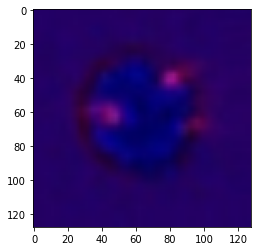

In [24]:
train_loader = torch.utils.data.DataLoader(
    data
    ,batch_size=64
    ,shuffle=True
    # ,pin_memory=True
    # ,num_workers=4
)

for data in tqdm(train_loader):
    print("size: ",data['x'][0].size())
    plt.imshow(data['x'][0].permute(1,2,0))
    plt.show()
    break

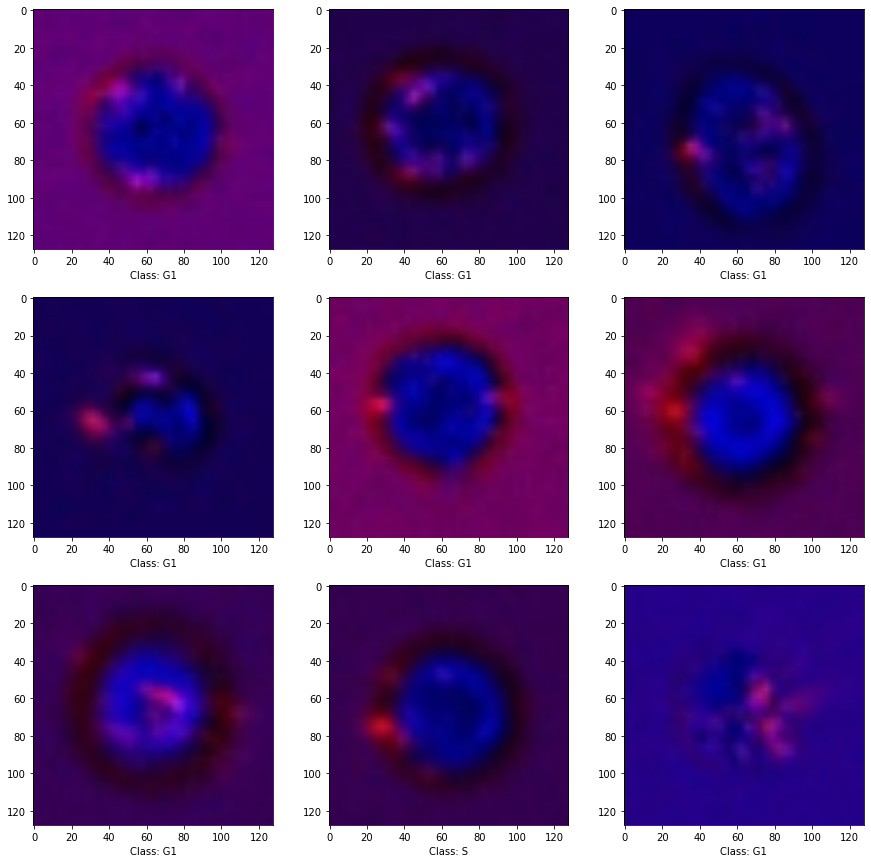

In [25]:
fig, ax = plt.subplots(3,3, figsize = (15,15))
class_dict = {'G1':0,
              'S': 1,
              'G2':2}

for i in range (9):
  batch = next(iter(train_loader))
  image, label=batch['x'],batch['y']
  #print(label)
  ax.flat[i].imshow(image[0].permute(1,2,0))
  
  text = "Class: "+list(class_dict.keys())[int(label[0])]
  ax.flat[i].set_xlabel(text)

In [37]:
#create folds
df = pd.read_csv('/content/cell_merged.csv')

df.loc[:,"kfold"] = -1

#df = df.sample(frac=1).reset_index(drop=True)

targets = df.drop("class_name", axis=1).values

NFOLDS = 10
mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
    df.loc[val, "kfold"] = fold
    
df.to_csv("./train_targets_folds.csv", index=False)

In [40]:
train_csv = pd.read_csv('./train_targets_folds.csv')
train_csv.head()

,Unnamed: 0,path,class_name,kfold
0,1,/content/CellCycle/G1/49778_merged.jpg,G1,7
1,3,/content/CellCycle/G1/19185_merged.jpg,G1,0
2,10,/content/CellCycle/G1/26027_merged.jpg,G1,2
3,13,/content/CellCycle/G1/19613_merged.jpg,G1,1
4,17,/content/CellCycle/G1/13599_merged.jpg,G1,3


In [49]:
class Engine:
      def __init__(self, model, optimizer, device, scheduler):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler

      @staticmethod
      def loss_fn(targets, outputs):
        return nn.CrossEntropyLoss() (outputs, targets)

      def train(self, data_loader):
        self.model.train()
        final_loss=0
        for data in tqdm(data_loader):
            self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(targets, outputs)
            loss.backward()
            
            self.optimizer.step()
            
            final_loss += loss.item()
        self.scheduler.step(1.)
        return(final_loss / len(data_loader))


      def evaluate(self, data_loader):
        self.model.train()
        final_loss=0
        for data in data_loader:
            #self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(targets, outputs)
            #loss.backward()
            #self.optimizer.step()
            final_loss += loss.item()
        return(final_loss / len(data_loader))


In [58]:

def run_training(fold, batch_size, lr, save_model=True, num_epochs = 69):

    val_fold=train_csv[train_csv['kfold'] == fold]
    train_fold=train_csv[train_csv['kfold'] != fold]
    
    
    train_dataset = C_Dataset(train_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )
    valid_dataset = C_Dataset(val_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )
    
    train_loader = torch.utils.data.DataLoader(
                    train_dataset
                    ,batch_size=batch_size
                    ,shuffle=False
                )

    val_loader = torch.utils.data.DataLoader(
                    valid_dataset
                    ,batch_size=256
                    ,shuffle=False
                )

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 3)
    model = model_ft.to(device)
    
    optimizer = optimizer = optim.Adam(model.parameters(), 
                                       lr = lr, 
                                       weight_decay=2e-5)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1,
                                                 patience=7, 
                                                 eps=1e-4, 
                                                 verbose=True)
    criterion = nn.CrossEntropyLoss() 
    eng = Engine(model, optimizer, device='cuda', scheduler = scheduler)
    
    best_loss = 999
    early_stop_iter = 10
    early_stop_count=0

    for epoch in tnrange(num_epochs):
        train_loss = eng.train(train_loader)
        valid_loss = eng.evaluate(val_loader)
        print("train_loss:", train_loss, "val_loss:", valid_loss)
        if valid_loss<best_loss:
            best_loss = valid_loss
            if save_model:
                torch.save(model.state_dict(), "model_"+str(fold)+".pth")
        else:
            early_stop_count +=1
            
        if early_stop_count>early_stop_iter:
            break
                    
    return(best_loss)

In [ ]:
best_losses = []
for fold in range(NFOLDS):
    best_losses.append(
        run_training(
            fold=fold,
            batch_size = 128,#best_params["batch_size"],
            lr = 0.0001,#best_params["lr"],
            num_epochs = 100
        )
    )